# **Reconstructing Fingerprint Images Using Autoencoder**

The [FVC2002](http://bias.csr.unibo.it/fvc2000/databases.asp) fingerprint dataset is a Fingerprint Verification Competition dataset which was organized back in the year 2000 and then again in the year 2002. This dataset consists of four different sensor fingerprints namely Low-cost Optical Sensor, Low-cost Capacitive Sensor, Optical Sensor and Synthetic Generator, each sensor having varying image sizes. The dataset has 320 images in set B, 80 images per sensor.

### Needed Packages

In [88]:
import os
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import numpy as np
from glob import glob
from scipy import misc
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
from PIL import Image
import keras
import gzip
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop

### Load the Data

In [89]:
! kaggle datasets download -d nageshsingh/fvc2002-fingerprints

Dataset URL: https://www.kaggle.com/datasets/nageshsingh/fvc2002-fingerprints
License(s): unknown
fvc2002-fingerprints.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip 'fvc2002-fingerprints.zip'

In [90]:
data = glob('/content/fingerprints/DB*/*')

In [91]:
len(data)

320

In [92]:
images = []
def read_images(data):
    for i in range(len(data)):
        img = misc.imread(data[i])
        img = misc.imresize(img,(224,224))
        images.append(img)
    return images

In [93]:
!pip install imageio
import imageio
from skimage.transform import resize  # Import resize from skimage

data = glob('/content/fingerprints/DB*/*')

images = []
def read_images(data):
    for i in range(len(data)):
        # Use imageio.imread
        img = imageio.imread(data[i])
        # Use resize function from skimage
        img = resize(img,(224,224))
        images.append(img)
    return images

images = read_images(data)

<ipython-input-93-cfdc23028d54>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(data[i])


In [94]:
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')

In [95]:
images_arr.shape

(320, 224, 224)

### Data Exploration

In [97]:
# Shapes of training set
print("Dataset (images) shape: {shape}".format(shape=images_arr.shape))

Dataset (images) shape: (320, 224, 224)


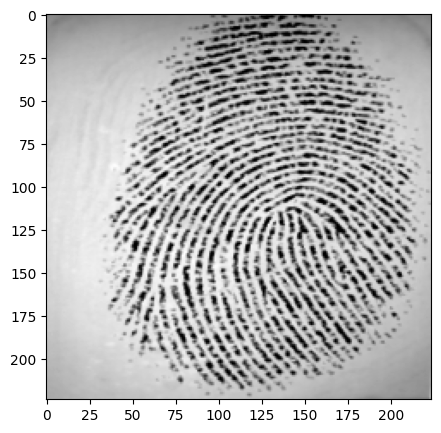

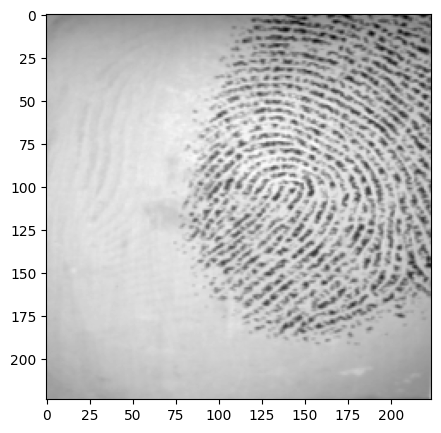

In [98]:
#plt.figure(figsize=[5,5])

# Display the first image in training data
for i in range(2):
    plt.figure(figsize=[5, 5])
    curr_img = np.reshape(images_arr[i], (224,224))
    plt.imshow(curr_img, cmap='gray')
    plt.show()


### Data Preprocessing

In [99]:
images_arr = images_arr.reshape(-1, 224,224, 1)

In [100]:
images_arr.shape

(320, 224, 224, 1)

In [101]:
images_arr.dtype

dtype('float32')

In [102]:
np.max(images_arr), np.min(images_arr)

(1.0, 0.0)

In [103]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr,
                                                             images_arr,
                                                             test_size=0.2,
                                                             random_state=13)

### Network: The Convolutional Autoencoder

In [104]:
batch_size = 16
epochs = 100
inChannel = 1
x, y = 224, 224
input_img = Input(shape = (x, y, inChannel))

In [105]:
input_img

<KerasTensor shape=(None, 224, 224, 1), dtype=float32, sparse=None, name=keras_tensor_60>

Encoder

The first layer will have 32 filters of size 3 x 3, followed by a downsampling (max-pooling) layer,
The second layer will have 64 filters of size 3 x 3, followed by another downsampling layer,
The final layer of encoder will have 128 filters of size 3 x 3.

Decoder

The first layer will have 128 filters of size 3 x 3 followed by an upsampling layer,
The second layer will have 64 filters of size 3 x 3 followed by another upsampling layer,
The final layer of encoder will have one filter of size 3 x 3.

In [106]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [107]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [108]:
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 224, 224, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,625 (1.20 MB)

 Trainable params: 314,625 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [109]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0667 - val_loss: 0.0444
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0469 - val_loss: 0.0341
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0362 - val_loss: 0.0267
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0243 - val_loss: 0.0251
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0246 - val_loss: 0.0172
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0199 - val_loss: 0.0240
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0226 - val_loss: 0.0215
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0235 - val_loss: 0.0312
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0188 - val_loss: 0.0160
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0224 - val_loss: 0.0182
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0174 - val_loss: 0.0186
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/ste

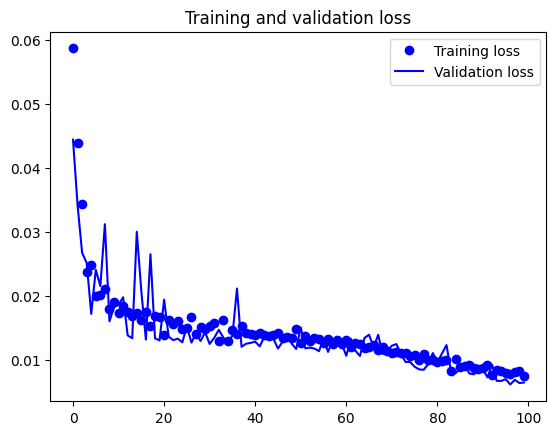

In [110]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predicting on Validation Data

In [111]:
pred = autoencoder.predict(valid_X)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


Test Images


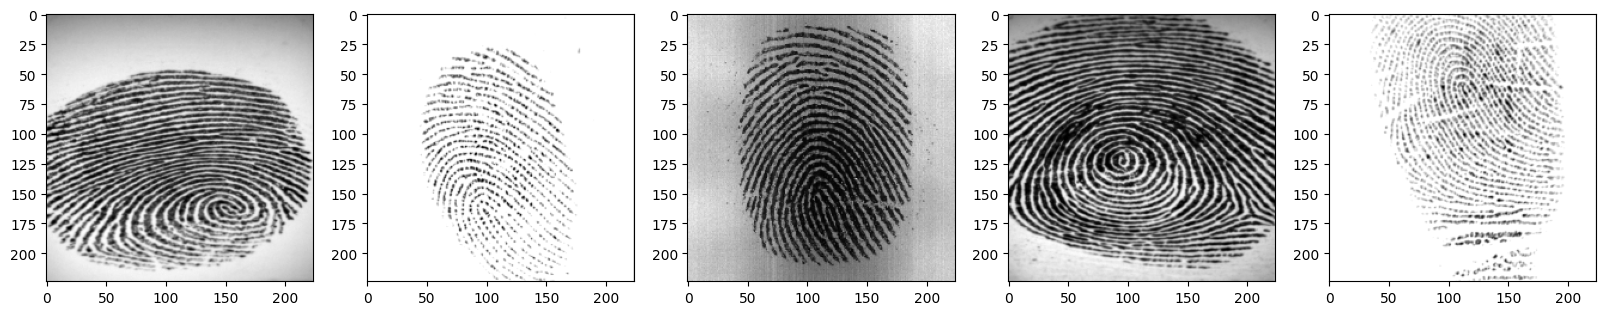

Reconstruction of Test Images


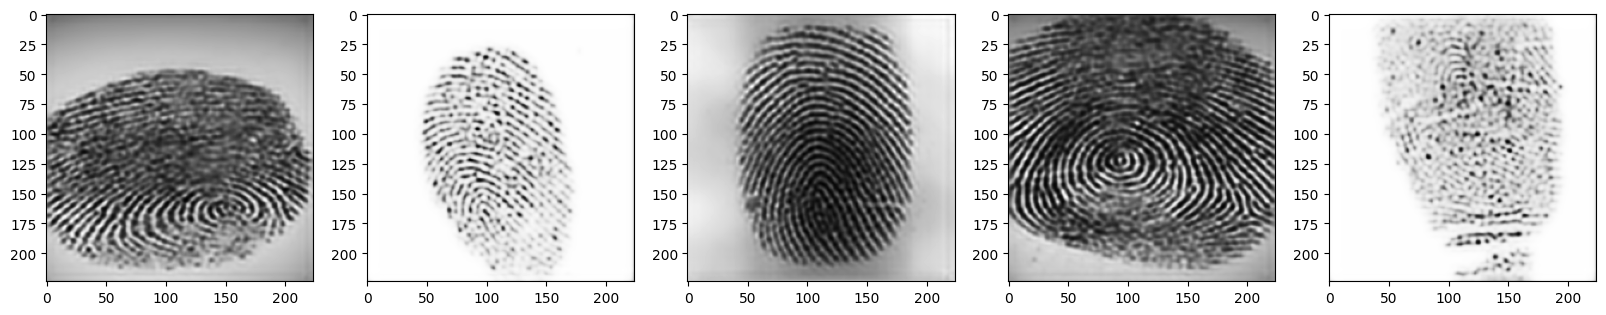

In [112]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')
plt.show()

### Predicting on Two Different Sensor Data using the Trained Model